In [28]:
import pandas as pd          # for extracting and manipulating data from dataset
import numpy as np           # for mathematical calculations
import matplotlib.pyplot as plt    # for plotting graphs
from datetime import datetime      # to access datetime
from sklearn.metrics import mean_squared_error
%matplotlib inline                
import warnings                    #  to ignore warnings
warnings.filterwarnings("ignore")

#reading train and test data
train = pd.read_csv ('C:/Users/gaura/Documents/Projects/Python Projects/Time series/Train data.csv')
test = pd.read_csv('C:/Users/gaura/Documents/Projects/Python Projects/Time series/Test data.csv')

#We make a copy of the data so that we do not lose the original data even after changes
train_original = train.copy()
test_original = test.copy()


# diving deeper in dataset 
train.columns, test.columns        # features in train and test


(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

In [4]:
train.shape, test.shape       # dimensions of train and test

((18288, 3), (5112, 2))

Test data has one less feature which is the target variable count of passengers corresponding to each datetime

In [23]:
print(train.dtypes, test.dtypes)      # data tyoes of each feature

train.head()   #first 5 rows of data

ID              float64
Count           float64
year            float64
month           float64
day             float64
Hour            float64
day of week     float64
weekend         float64
dtype: object ID       float64
year     float64
month    float64
day      float64
Hour     float64
dtype: object


,ID,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,,
2012-08-25,11.5,3.166667,2012.0,8.0,25.0,11.5,5.0,1.0
2012-08-26,35.5,3.666667,2012.0,8.0,26.0,11.5,6.0,1.0
2012-08-27,59.5,2.583333,2012.0,8.0,27.0,11.5,0.0,0.0
2012-08-28,83.5,2.416667,2012.0,8.0,28.0,11.5,1.0,0.0
2012-08-29,107.5,2.500000,2012.0,8.0,29.0,11.5,2.0,0.0


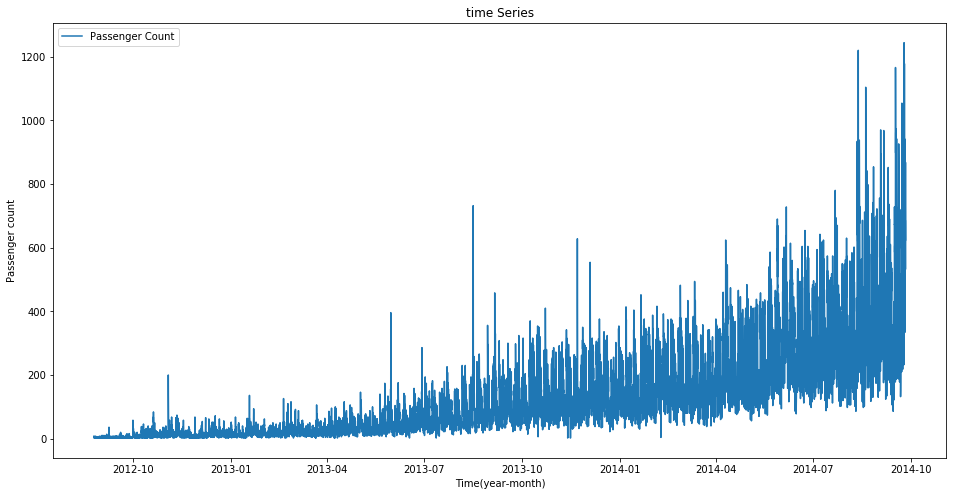

In [6]:
# Changing the object of Datetime in train and test data to 'datetime' to extract features from it
train['Datetime'] = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(test_original.Datetime, format= '%d-%m-%Y %H:%M')
test_original ['Datetime'] = pd.to_datetime(test_original.Datetime, format= '%d-%m-%Y %H:%M')

# To extract the year, month, day and hour to make further analysis
for i in (train, test, test_original, train_original):
    i['year'] = i.Datetime.dt.year
    i['month'] = i.Datetime.dt.month
    i['day'] = i.Datetime.dt.day
    i['Hour'] = i.Datetime.dt.hour
    
#To generate weekend and weekday variables
train['day of week '] = train['Datetime'].dt.dayofweek
temp = train ['Datetime']

#We assign 1 if the day of week is weekend and 0 if the day of week is weekday
def applyer(row):
    if row.dayofweek==5 or row.dayofweek == 6:
        return 1
    else:
        return 0
    
train['weekend'] = train ['Datetime'].apply(applyer)

#assigning index as Datetime to get the time period on x-axis.
train.index = train['Datetime']
df = train.drop('ID',1)
ts= train.Count
plt.figure(figsize=(16,8))
plt.plot(ts, label = 'Passenger Count')
plt.title ('time Series')
plt.xlabel('Time(year-month)')
plt.ylabel ('Passenger count')
plt.legend(loc = 'best')

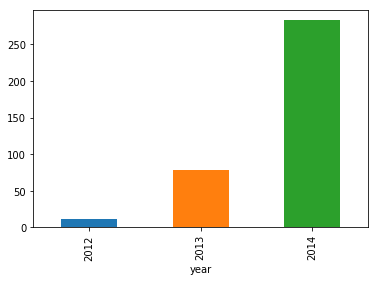

In [7]:
#General trend is increase in passenger count with increase in time. Next we do EXPLORATORY ANALYSIS

#To check yearly passenger count
train.groupby('year')['Count'].mean().plot.bar()

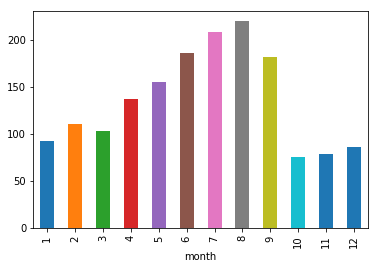

In [8]:
# Passenger count increase exponentially with increase in years. Let's check for months.

train.groupby('month')['Count'].mean().plot.bar()

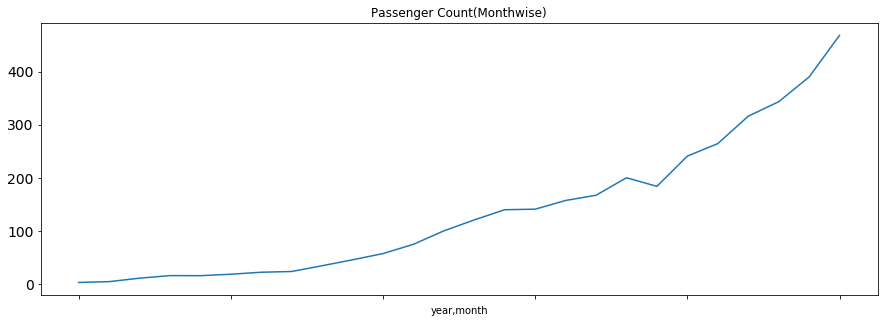

In [9]:
# we see a monthly decrease in the mean of passenger count in last three months
temp  = train.groupby(['year', 'month'])['Count'].mean()
temp.plot(figsize = (15,5), title = 'Passenger Count(Monthwise)', fontsize = 14)

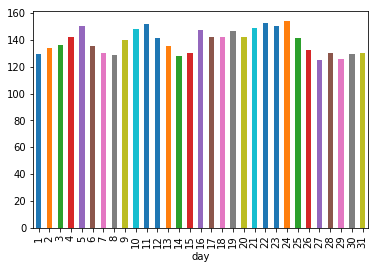

In [12]:
#Year 2014 does not has last three months that is the reason we are getting less counts for these months
train.groupby('day')['Count'].mean().plot.bar()

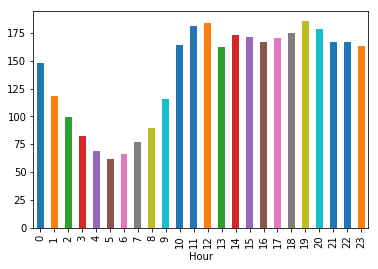

In [10]:
#not much insights available from day wise counts. Let's check the mean of hourly passenger count
train.groupby('Hour')['Count'].mean().plot.bar()

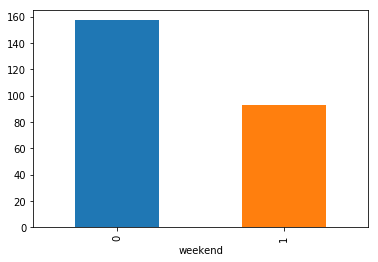

In [11]:
#Peak traffic os at 7 pm and then it decreases till 5 am. Let's check the traffic trend for weekends.
train.groupby('weekend')['Count'].mean().plot.bar()

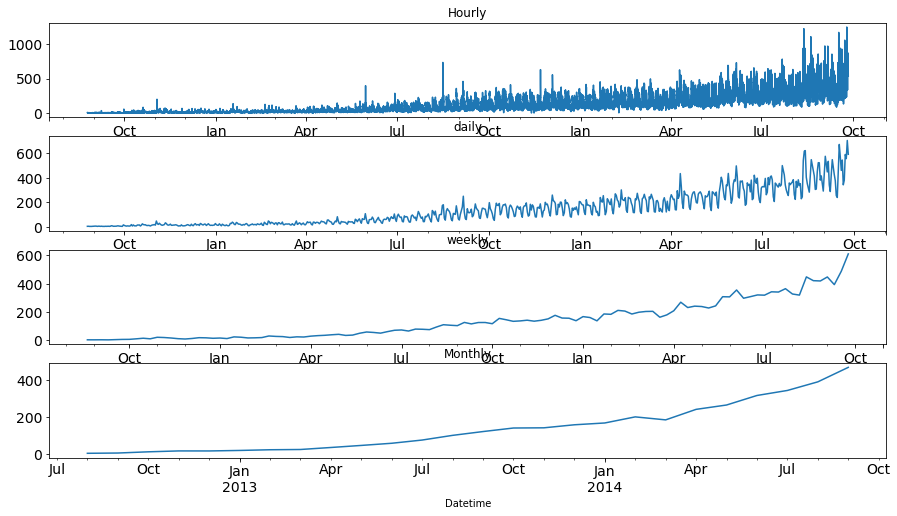

In [13]:
#Clearly traffic is more on weekdays than weekends.
# Before oving forward to modelling we have to drop the ID variable as it has got nothing to do with passenger count


# We aggregate hourly time series to daily, weekly and monthly to reduce the noise and make it more stable for model to learn
hourly = train.resample('H').mean()
daily = train.resample('D').mean()
weekly = train.resample('W').mean()
monthly = train.resample('M').mean()

fig,ax = plt.subplots(4,1)
hourly.Count.plot(figsize= (15,8), title = 'Hourly', fontsize= 14, ax = ax[0])
daily.Count.plot(figsize=(15,8), title = 'daily', fontsize= 14, ax=ax [1])
weekly.Count.plot(figsize=(15,8), title = 'weekly', fontsize = 14, ax = ax [2])
monthly.Count.plot(figsize=(15,8), title = 'Monthly', fontsize= 14, ax = ax [3])

plt.show()


We can see that the time series is becoming more and more stable. So we will work with the daily time series

In [14]:
# We can see that the time series is becoming more and more stable. So we will work with the daily time series

test.Timestamp = pd.to_datetime(test.Datetime, format = '%d-%m-%Y %H:%M')
test.index = test.Timestamp
test = test.resample('D').mean()

train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
train.index = train.Timestamp
train = train.resample('D').mean()


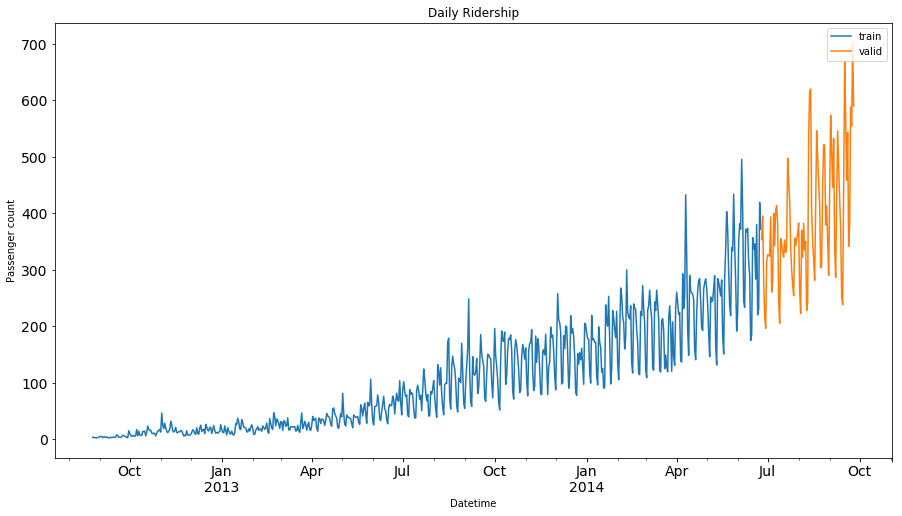

In [22]:
# Splitting the data into training and Validation. We take last 3 months as our validation data and rest as training data

Train = train.ix['2012-08-25' : '2014-06-24']
valid = train.ix['2014-06-25' : '2014-09-25']

Train.Count.plot(label = 'train')
valid.Count.plot(figsize= (15,8), title = 'Daily Ridership', fontsize = 14 , label = 'valid')
plt.xlabel("Datetime")
plt.ylabel("Passenger count")
plt.legend(loc = 'upper right')
plt.show()

Blue part reperesents the training data and orange part is validating data. Next we look at the different modelling techniques for forecasting.


**1) Naive Approach**- In this approach we assume that the next expected point is equal to the last observed point

Text(0.5, 1.0, 'Naive Forecast')

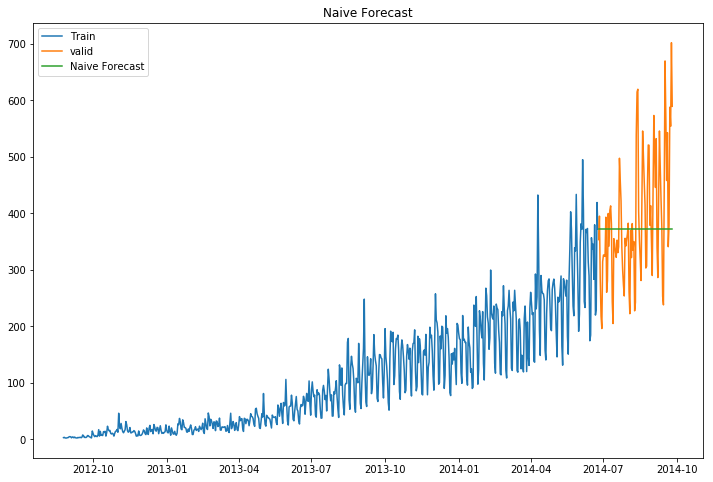

In [27]:
dd = np.asarray(Train.Count)        # to convert the train to array
y_hat = valid.copy()                # copy of validation set
y_hat['naive'] = dd[len(dd)-1]      # new column for naive forecasted values all equal to the last value of train data
plt.figure (figsize=(12,8))
plt.plot(Train.index, Train['Count'], label = 'Train')
plt.plot(valid.index, valid['Count'], label = 'valid')
plt.plot(y_hat.index, y_hat['naive'], label = 'Naive Forecast')
plt.legend (loc= 'best')
plt.title('Naive Forecast')

We compute the accuracy of our using Root Mean Squared Error (RMSE) on the validation set

In [30]:
from math import sqrt
rms= sqrt(mean_squared_error(valid.Count, y_hat.naive))
print (rms)

111.79050467496724


We can tell intuitively that this error value can be reduced using better algorithms

**2) Moving Average** - In this technique we take the average of the passenger counts for last few time periods only

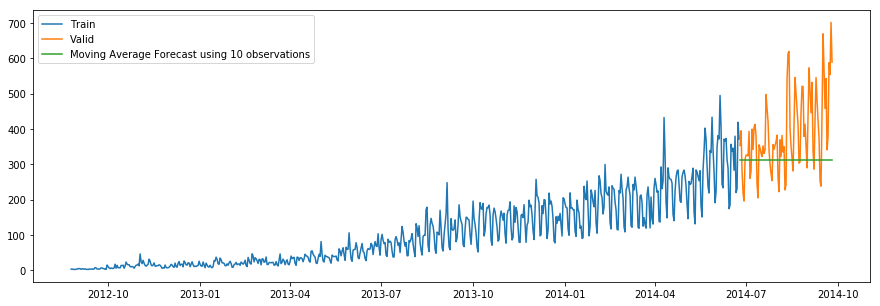

RMSE=  134.23733308950264


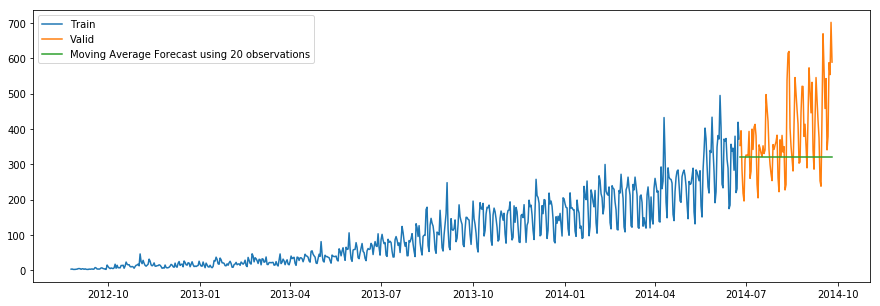

RMSE=  130.44984977550422


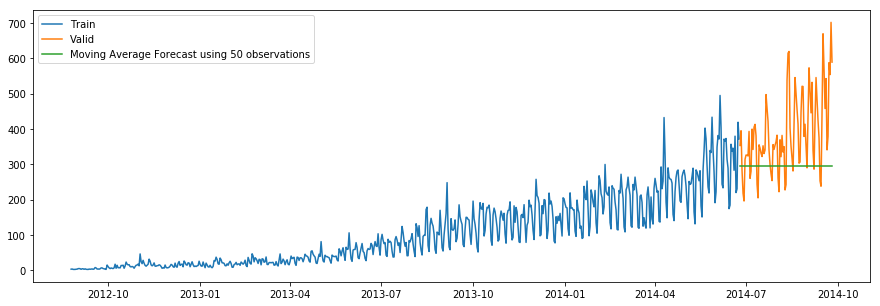

RMSE=  144.19175679986802


In [32]:
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(10).mean().iloc[-1] # average of last 10 observations.
plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 10 observations')
plt.legend(loc='best')
plt.show()
print('RMSE= ',sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast)))
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(20).mean().iloc[-1] # average of last 20 observations.
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 20 observations')
plt.legend(loc='best')
plt.show()
print('RMSE= ',sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast)))
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(50).mean().iloc[-1] # average of last 50 observations.
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 50 observations')
plt.legend(loc='best')
plt.show()
print('RMSE= ',sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast)))

We see that the errors are increasing that means the predictions are getting weaker with increasing the rolling observations.

**3) Simple Exponential Smoothing** - In this technique we assign larger weights to more recent observations than to observations from the distant past. The weights reduce exponentially from recent to oldest observations

RMSE =  113.43708111884514


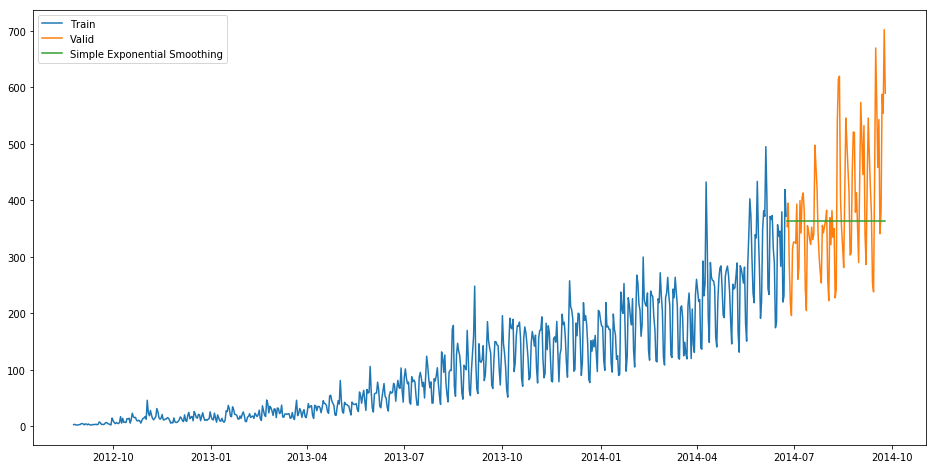

In [39]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = valid.copy()
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level = 0.6, optimized = False)
y_hat_avg['SES'] = fit2.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label = 'Train')
plt.plot(valid['Count'], label = 'Valid')
plt.plot(y_hat_avg['SES'], label = 'Simple Exponential Smoothing')
plt.legend(loc ='best')
print('RMSE = ', sqrt(mean_squared_error(valid.Count, y_hat_avg.SES)))

RMSE is lower than moving average method. <br>
<br>
**4) Holt's linear trend model**- It is an extension pf exponential method to allow forecasting of data with a trend. The algortihm is a function of level and trend.<br>First of all let us visualize the trend, seasonality and error in the series.<br>

We can decompose the time series in four parts.

1) Observed, which is the original time series.<br>
2) Trend, which shows the trend in the time series, i.e., increasing or decreasing behaviour of the time series.<br>
3) Seasonal, which tells us about the seasonality in the time series.<br>
4) Residual, which is obtained by removing any trend or seasonality in the time series.<br>


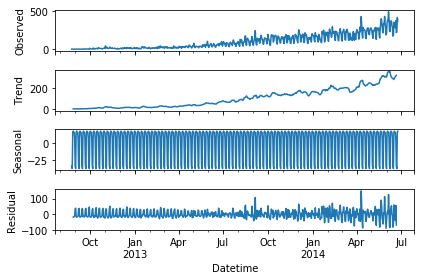

In [43]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(Train.Count).plot()
resut = sm.tsa.stattools.adfuller(train.Count)
plt.show()

We can see that the trend is increasing so lets forecast the passenger count based on Holt's method.

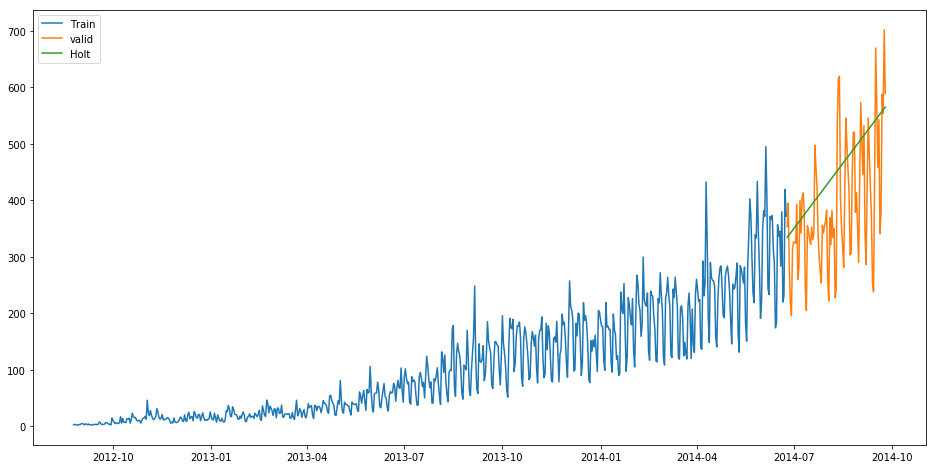

RMSE =  112.94278345314041


In [48]:
y_hat_avg = valid.copy()
fit1 = Holt(np.asarray(Train.Count)).fit(smoothing_level = 0.3, smoothing_slope = 0.1)
y_hat_avg['Holt'] = fit1.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot(Train.Count, label = 'Train')
plt.plot(valid.Count, label = 'valid')
plt.plot(y_hat_avg.Holt, label = 'Holt')
plt.legend(loc = 'best')
plt.show()
print('RMSE = ', sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt)))

We see that the RMSE value has further decreased from Simple Exponential Smoothing. Let's apply Holt Winter's model.<br> <br>
**4) Holt Winter's model on daily time series** - For datasets which show a similar set of patterns after fixed intervals of time or seasonality which the earlier models didn't take into account. Holt Winter's method applies seasonality in addition to level and trend.
